# (VAD) Velocity Azimuth Display

Argonne National Laboratory

Original code by Jonathan Helmus

In [19]:
%%time
import glob
from matplotlib import animation
import matplotlib.pyplot as plt
import netCDF4
import numpy.ma as ma
import numpy as np
import pyart
import warnings
# warnings.filterwarnings("ignore")
%matplotlib inline
from IPython.display import Image, display


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

CPU times: user 724 ms, sys: 360 ms, total: 1.08 s
Wall time: 1.01 s


In [20]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _vad_calculation
    _inverse_dist_squared
    _Average1D

"""

import numpy as np

from pyart.core import HorizontalWindProfile


def velocity_azimuth_display_jon(
        radar, velocity, z_want=None,
        valid_ray_min=16, gatefilter=None, window=2,
        weight='equal'):
    """
    Velocity azimuth display.

    Note: If a specific sweep is desired, before using the
    velocity_azimuth_display function, use, for example:
    one_sweep_radar = radar.extract_sweeps([0])

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Array of desired heights to be sampled for the vad
        calculation.
    valid_ray_min : int
        Amount of rays required to include that level in
        the VAD calculation.
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded when
        from the vad calculation.
    window : int
        Value to use for window when determing new values in the
        _Averag1D function.
    weight : string
        A string to indicate weighting method to use. 'equal' for
        equal weighting when interpolating or 'idw' for inverse
        distribution squared weighting for interpolating.
        Default is 'equal'.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ---------
    K. A. Browning and R. Wexler, 1968: The Determination
    of Kinematic Properties of a Wind Field Using Doppler
    Radar. J. Appl. Meteor., 7, 105–113

    """
    velocities = radar.fields[velocity]['data']
    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded, velocities)
    #mask=velocities.mask
    #velocities[np.where(mask)]=np.nan
    azimuths = radar.azimuth['data'][:]
    elevation = radar.fixed_angle['data'][0]

    u_wind, v_wind = _vad_calculation_j(velocities, azimuths,
                                        elevation, valid_ray_min)
    bad = np.logical_or(np.isnan(u_wind), np.isnan(v_wind))
    good_u_wind = u_wind[~bad]
    good_v_wind = v_wind[~bad]

    radar_height = radar.gate_z['data'][0]
    good_height = radar_height[~bad]
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)
    try:
        print('max height', np.max(good_height), ' meters')
        print('min height', np.min(good_height), ' meters')
    except ValueError:
        raise ValueError('Not enough data in this radar sweep ' \
                         'for a vad calculation.')

    u_interp = _Average1D(good_height, good_u_wind,
                          z_want[1] - z_want[0] / window, weight)
    v_interp = _Average1D(good_height, good_v_wind,
                          z_want[1] - z_want[0] / window, weight)

    u_wanted = u_interp(z_want)
    v_wanted = v_interp(z_want)
    u_wanted = np.ma.masked_equal(u_wanted, 99999.)
    v_wanted = np.ma.masked_equal(v_wanted, 99999.)

    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_wanted, v_wanted)
    return vad

def _vad_calculation_j(velocities, azimuths,
                       elevation, valid_ray_min):
    """ Calculates VAD for a scan and returns u_mean and
    v_mean. velocities is a 2D array, azimuths is a 1D
    array, elevation is a number.

    Jonathan's Note:
    We need to solve: Ax = b
    where:
    A = [sum_sin_squared_az, sum_sin_cos_az    ] = [a, b]
        [sum_sin_cos_az,     sum_cos_squared_az]   [c, d]
    b = [sum_sin_vel_dev] = [b_1]
        [sum_cos_vel_dev]   [b_2]
    The solution to this is:
    x = A-1 * b

    A-1 is:
     1    [ d,  -b ]
    --- * [ -c,  a ]
    |A|

    and the determinate, det is: det = a*d - b*c

    Therefore the elements of x are:

    x_1 = (d* b_1  + -b * b_2) / det = (d*b_1 - b*b_2) / det
    x_2 = (-c * b_1 +  a * b_2) / det = (a*b_2 - c*b_1) / det

    """
    velocities = velocities.filled(np.nan)
    shape = velocities.shape
    _, nbins = velocities.shape

    invalid = np.isnan(velocities)
    valid_rays_per_gate = np.sum(~np.isnan(velocities), axis=0)
    too_few_valid_rays = valid_rays_per_gate < valid_ray_min
    invalid[:, too_few_valid_rays] = True

    sin_az = np.sin(np.deg2rad(azimuths))
    cos_az = np.cos(np.deg2rad(azimuths))
    sin_az = np.repeat(sin_az, nbins).reshape(shape)
    cos_az = np.repeat(cos_az, nbins).reshape(shape)
    sin_az[invalid] = np.nan
    cos_az[invalid] = np.nan

    mean_velocity_per_gate = np.nanmean(velocities, axis=0).reshape(1, -1)
    velocity_deviation = velocities - mean_velocity_per_gate

    sum_cos_vel_dev = np.nansum(cos_az * velocity_deviation, axis=0)
    sum_sin_vel_dev = np.nansum(sin_az * velocity_deviation, axis=0)

    sum_sin_cos_az = np.nansum(sin_az * cos_az, axis=0)
    sum_sin_squared_az = np.nansum(sin_az**2, axis=0)
    sum_cos_squared_az = np.nansum(cos_az**2, axis=0)

    # The A matrix
    a = sum_sin_squared_az
    b = sum_sin_cos_az
    c = sum_sin_cos_az
    d = sum_cos_squared_az

    # The b vector
    b_1 = sum_sin_vel_dev
    b_2 = sum_cos_vel_dev

    # solve for the x vector
    determinant = a*d - b*c
    x_1 = (d*b_1 - b*b_2) / determinant
    x_2 = (a*b_2 - c*b_1) / determinant

    # calculate horizontal components of winds
    elevation_scale = 1 / np.cos(np.deg2rad(elevation))
    u_mean = x_1 * elevation_scale
    v_mean = x_2 * elevation_scale
    return u_mean, v_mean


def _inverse_dist_squared(dist):
    """ Obtaining distance weights by using distance weighting
    interpolation, using the inverse distance-squared relationship.
    """
    weights = 1 / (dist * dist)
    weights[np.isnan(weights)] = 99999.
    return weights


class _Average1D(object):
    """ Used to find the nearest gate height and horizontal wind
    value with respect to the user's desired height. """
    def __init__(self, x, y, window, weight,
                 fill_value=99999.):
        sort_idx = np.argsort(x)
        self.x_sorted = x[sort_idx]
        self.y_sorted = y[sort_idx]
        self.window = window
        self.fill_value = fill_value

        if weight == 'equal':
            self.weight_func = lambda x: None
        elif weight == 'idw':
            self.weight_func = _inverse_dist_squared
        elif callable(weight):
            self.weight_func = weight
        else:
            raise ValueError("Invalid weight argument:", weight)

    def __call__(self, x_new, window=None):
        if window is None:
            window = self.window
        y_new = np.zeros_like(x_new, dtype=self.y_sorted.dtype)
        for i, center in enumerate(x_new):

            bottom = center - window
            top = center + window
            start = np.searchsorted(self.x_sorted, bottom)
            stop = np.searchsorted(self.x_sorted, top)

            x_in_window = self.x_sorted[start:stop]
            y_in_window = self.y_sorted[start:stop]
            if len(x_in_window) == 0:
                y_new[i] = self.fill_value
            else:
                distances = x_in_window - center
                weights = self.weight_func(distances)
                y_new[i] = np.average(y_in_window, weights=weights)
        return y_new

In [21]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _interval_mean
    _sd_to_uv
    _vad_calculation

"""

import numpy as np

from pyart.config import get_field_name
from pyart.core import HorizontalWindProfile


def velocity_azimuth_display_scott(radar, vel_field=None, z_want=None,
                                   gatefilter=None):
    """
    Velocity azimuth display.
    
    Creates a VAD object containing U Wind V Wind and height, that
    can then be used to plot and produces the velocity azimuth
    display.

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Heights for where to sample vads from.
        None will result in np.linespace(0, 10000, 100).
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the vad calculation.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ---------
    Michelson, D. B., Andersson, T., Koistinen, J., Collier, C. G., Riedl, J.,
    Szturc, J., Gjertsen, U., Nielsen, A. and Overgaard, S. (2000) BALTEX Radar
    Data Centre Products and their Methodologies. In SMHI Reports. Meteorology
    and Climatology. Swedish Meteorological and Hydrological Institute, Norrkoping.

    """
    speeds = []
    angles = []
    heights = []
    z_gate_data = radar.gate_z['data']
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)

    if vel_field is None:
        vel_field = get_field_name('velocity')

    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded,
            radar.fields[vel_field]['data'])
    else:
        velocities = radar.fields[vel_field]['data']

    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i]
        if not (index_end - index_start) % 2 == 0:
            index_end = index_end - 1

        used_velocities = velocities[index_start:index_end]
        azimuth = radar.azimuth['data'][index_start:index_end]
        elevation = radar.fixed_angle['data'][i]
        speed, angle = _vad_calculation_s(
            used_velocities, azimuth, elevation)

        bad = np.isnan(speed)
        print('max height', z_gate_data[index_start, :].max(),
              'meters')
        speeds.append(speed[~bad])
        angles.append(angle[~bad])
        heights.append(z_gate_data[index_start, :][~bad])

    speed_array = np.concatenate(speeds)
    angle_array = np.concatenate(angles)
    height_array = np.concatenate(heights)
    arg_order = height_array.argsort()
    speed_ordered = speed_array[arg_order]
    height_ordered = height_array[arg_order]
    angle_ordered = angle_array[arg_order]
    u_ordered, v_ordered = _sd_to_uv(speed_ordered, angle_ordered)
    u_mean = _interval_mean(u_ordered, height_ordered, z_want)
    v_mean = _interval_mean(v_ordered, height_ordered, z_want)
    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_mean, v_mean)
    return vad


def _vad_calculation_s(velocity_field, azimuth, elevation):
    """ Calculates VAD for a scan, returns speed and angle
    outdic = vad_algorithm(velocity_field, azimuth, elevation)
    velocity_field is a 2D array, azimuth is a 1D array,
    elevation is a number. All in degrees, m outdic contains
    speed and angle. """
    nrays, nbins = velocity_field.shape
    nrays2 = nrays // 2
    velocity_count = np.empty((nrays2, nbins, 2))
    velocity_count[:, :, 0] = velocity_field[0:nrays2, :]
    velocity_count[:, :, 1] = velocity_field[nrays2:, :]
    sinaz = np.sin(np.deg2rad(azimuth))
    cosaz = np.cos(np.deg2rad(azimuth))
    sumv = np.ma.sum(velocity_count, 2)
    vals = np.isnan(sumv)
    vals2 = np.vstack((vals, vals))

    # Line below needs to be changed to 'is not' expression.
    count = np.sum(np.isnan(sumv) == False, 0)

    aa = count < 8
    vals[:, aa] = 0
    vals2[:, aa] = 0
    count = np.float64(count)
    count[aa] = np.nan
    u_m = np.array([np.nansum(sumv, 0) // (2 * count)])
    count[aa] = 0

    cminusu_mcos = np.zeros((nrays, nbins))
    cminusu_msin = np.zeros((nrays, nbins))
    sincos = np.zeros((nrays, nbins))
    sin2 = np.zeros((nrays, nbins))
    cos2 = np.zeros((nrays, nbins))

    for i in range(nbins):
        cminusu_mcos[:, i] = cosaz * (velocity_field[:, i] - u_m[:, i])
        cminusu_msin[:, i] = sinaz * (velocity_field[:, i] - u_m[:, i])
        sincos[:, i] = sinaz * cosaz
        sin2[:, i] = sinaz**2
        cos2[:, i] = cosaz**2

    cminusu_mcos[vals2] = np.nan
    cminusu_msin[vals2] = np.nan
    sincos[vals2] = np.nan
    sin2[vals2] = np.nan
    cos2[vals2] = np.nan
    sumcminu_mcos = np.nansum(cminusu_mcos, 0)
    sumcminu_msin = np.nansum(cminusu_msin, 0)
    sumsincos = np.nansum(sincos, 0)
    sumsin2 = np.nansum(sin2, 0)
    sumcos2 = np.nansum(cos2, 0)
    b_value = (sumcminu_mcos - (sumsincos*sumcminu_msin / sumsin2)) / (
        sumcos2 - (sumsincos**2) / sumsin2)
    a_value = (sumcminu_msin - b_value*sumsincos) / sumsin2
    speed = np.sqrt(a_value**2 + b_value**2) / np.cos(
        np.deg2rad(elevation))
    angle = np.arctan2(a_value, b_value)
    return speed, angle


def _interval_mean(data, current_z, wanted_z):
    """ Find the mean of data indexed by current_z
        at wanted_z on intervals wanted_z+/- delta
        wanted_z. """
    delta = wanted_z[1] - wanted_z[0]
    pos_lower = [np.argsort((current_z - (
        wanted_z[i] - delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    pos_upper = [np.argsort((current_z - (
        wanted_z[i] + delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    mean_values = np.array([data[pos_lower[i]:pos_upper[i]].mean()
                            for i in range(len(pos_upper))])
    return mean_values


def _sd_to_uv(speed, direction):
    """ Takes speed and direction to create u_mean and v_mean. """
    return (np.sin(direction) * speed), (np.cos(direction) * speed)

In [22]:
files = sorted(glob.glob('/home/zsherman/dev/xsapr_sgp/data/05_19_2017/*'"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _interval_mean
    _sd_to_uv
    _vad_calculation

"""

import numpy as np

from pyart.config import get_field_name
from pyart.core import HorizontalWindProfile



def velocity_azimuth_display_scott(radar, vel_field=None, z_want=None,
                                   gatefilter=None):
    """
    Velocity azimuth display.
    
    Creates a VAD object containing U Wind V Wind and height, that
    can then be used to plot and produces the velocity azimuth
    display.

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Heights for where to sample vads from.
        None will result in np.linespace(0, 10000, 100).
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the vad calculation.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ---------
    Michelson, D. B., Andersson, T., Koistinen, J., Collier, C. G., Riedl, J.,
    Szturc, J., Gjertsen, U., Nielsen, A. and Overgaard, S. (2000) BALTEX Radar
    Data Centre Products and their Methodologies. In SMHI Reports. Meteorology
    and Climatology. Swedish Meteorological and Hydrological Institute, Norrkoping.

    """
    speeds = []
    angles = []
    heights = []
    z_gate_data = radar.gate_z['data']
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)

    if vel_field is None:
        vel_field = get_field_name('velocity')

    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded,
            radar.fields[vel_field]['data'])
    else:
        velocities = radar.fields[vel_field]['data']

    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i]
        if not (index_end - index_start) % 2 == 0:
            index_end = index_end - 1

        used_velocities = velocities[index_start:index_end]
        azimuth = radar.azimuth['data'][index_start:index_end]
        elevation = radar.fixed_angle['data'][i]
        speed, angle = _vad_calculation_s(
            used_velocities, azimuth, elevation)

        bad = np.isnan(speed)
        print('max height', z_gate_data[index_start, :].max(),
              'meters')
        speeds.append(speed[~bad])
        angles.append(angle[~bad])
        heights.append(z_gate_data[index_start, :][~bad])

    speed_array = np.concatenate(speeds)
    angle_array = np.concatenate(angles)
    height_array = np.concatenate(heights)
    arg_order = height_array.argsort()
    speed_ordered = speed_array[arg_order]
    height_ordered = height_array[arg_order]
    angle_ordered = angle_array[arg_order]
    u_ordered, v_ordered = _sd_to_uv(speed_ordered, angle_ordered)
    u_mean = _interval_mean(u_ordered, height_ordered, z_want)
    v_mean = _interval_mean(v_ordered, height_ordered, z_want)
    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_mean, v_mean)
    return vad


def _vad_calculation_s(velocity_field, azimuth, elevation):
    """ Calculates VAD for a scan, returns speed and angle
    outdic = vad_algorithm(velocity_field, azimuth, elevation)
    velocity_field is a 2D array, azimuth is a 1D array,
    elevation is a number. All in degrees, m outdic contains
    speed and angle. """
    nrays, nbins = velocity_field.shape
    nrays2 = nrays // 2
    velocity_count = np.empty((nrays2, nbins, 2))
    velocity_count[:, :, 0] = velocity_field[0:nrays2, :]
    velocity_count[:, :, 1] = velocity_field[nrays2:, :]
    sinaz = np.sin(np.deg2rad(azimuth))
    cosaz = np.cos(np.deg2rad(azimuth))
    sumv = np.ma.sum(velocity_count, 2)
    vals = np.isnan(sumv)
    vals2 = np.vstack((vals, vals))

    # Line below needs to be changed to 'is not' expression.
    count = np.sum(np.isnan(sumv) == False, 0)

    aa = count < 8
    vals[:, aa] = 0
    vals2[:, aa] = 0
    count = np.float64(count)
    count[aa] = np.nan
    u_m = np.array([np.nansum(sumv, 0) // (2 * count)])
    count[aa] = 0

    cminusu_mcos = np.zeros((nrays, nbins))
    cminusu_msin = np.zeros((nrays, nbins))
    sincos = np.zeros((nrays, nbins))
    sin2 = np.zeros((nrays, nbins))
    cos2 = np.zeros((nrays, nbins))

    for i in range(nbins):
        cminusu_mcos[:, i] = cosaz * (velocity_field[:, i] - u_m[:, i])
        cminusu_msin[:, i] = sinaz * (velocity_field[:, i] - u_m[:, i])
        sincos[:, i] = sinaz * cosaz
        sin2[:, i] = sinaz**2
        cos2[:, i] = cosaz**2

    cminusu_mcos[vals2] = np.nan
    cminusu_msin[vals2] = np.nan
    sincos[vals2] = np.nan
    sin2[vals2] = np.nan
    cos2[vals2] = np.nan
    sumcminu_mcos = np.nansum(cminusu_mcos, 0)
    sumcminu_msin = np.nansum(cminusu_msin, 0)
    sumsincos = np.nansum(sincos, 0)
    sumsin2 = np.nansum(sin2, 0)
    sumcos2 = np.nansum(cos2, 0)
    b_value = (sumcminu_mcos - (sumsincos*sumcminu_msin / sumsin2)) / (
        sumcos2 - (sumsincos**2) / sumsin2)
    a_value = (sumcminu_msin - b_value*sumsincos) / sumsin2
    speed = np.sqrt(a_value**2 + b_value**2) / np.cos(
        np.deg2rad(elevation))
    angle = np.arctan2(a_value, b_value)
    return speed, angle


def _interval_mean(data, current_z, wanted_z):
    """ Find the mean of data indexed by current_z
        at wanted_z on intervals wanted_z+/- delta
        wanted_z. """
    delta = wanted_z[1] - wanted_z[0]
    pos_lower = [np.argsort((current_z - (
        wanted_z[i] - delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    pos_upper = [np.argsort((current_z - (
        wanted_z[i] + delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    mean_values = np.array([data[pos_lower[i]:pos_upper[i]].mean()
                            for i in range(len(pos_upper))])
    return mean_values


def _sd_to_uv(speed, direction):
    """ Takes speed and direction to create u_mean and v_mean. """
    return (np.sin(direction) * speed), (np.cos(direction) * speed)))

In [7]:
def animate(nframe):
    plt.clf()
    
    radar = pyart.io.read(files[nframe])
    radar_sweep = radar.extract_sweeps([13])
    height = np.linspace(0, 13000, 201)
    valid_ray_min = 16

    # perform a VAD retrieval
    vad_j = velocity_azimuth_display_jon(
        radar_sweep, 'velocity', z_want=height, gatefilter=None,
        valid_ray_min=valid_ray_min)
    vad_s = velocity_azimuth_display_scott(
        radar_sweep, 'velocity', z_want=height,
        gatefilter=None)

    ax1 = fig.add_subplot(131)
    display = pyart.graph.RadarMapDisplay(radar_sweep)
    display.plot_ppi_map('reflectivity', resolution='l',
                         vmin=-8, vmax=64, mask_outside=False,
                         cmap=pyart.graph.cm.NWSRef,
                         lat_lines=None, ax=ax1, lon_lines=None)
    display.basemap.drawcounties()

    ax2 = fig.add_subplot(132)
    plt.plot(vad_j.u_wind, vad_j.height, 'b-', label='U Wind')
    plt.plot(vad_j.v_wind, vad_j.height, 'r-', label='V Wind')
    plt.xlim(-25, 25)
    plt.ylim(0, 13000)
    plt.title("Jonathan's VAD")
    plt.legend()
    
    ax3 = fig.add_subplot(133)
    plt.plot(vad_s.u_wind, vad_s.height, 'b-', label='U Wind')
    plt.plot(vad_s.v_wind, vad_s.height, 'r-', label='V Wind')
    plt.xlim(-25, 25)
    plt.ylim(0, 13000)
    plt.title("Scott's VAD")
    plt.legend()
    
    del radar
    del radar_sweep

fig = plt.figure(figsize=(22, 6))
anim = animation.FuncAnimation(fig, animate,
                               frames=len(files))
anim.save('/home/zsherman/vad_compare_sweep13.gif', writer='imagemagick', fps=1)
plt.close()

max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12231.5456165  meters
min height 0.0  meters
max height 12231.5456165  meters
12231.5456165


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12233.8679414  meters
min height 0.0  meters
max height 12233.8679414  meters
12233.8679414


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12236.1902379  meters
min height 0.0  meters
max height 12236.1902379  meters
12236.1902379


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12224.5784716  meters
min height 0.0  meters
max height 12224.5784716  meters
12224.5784716


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12236.1902379  meters
min height 0.0  meters
max height 12236.1902379  meters
12236.1902379


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12254.7675872  meters
min height 0.0  meters
max height 12254.7675872  meters
12254.7675872


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12254.7675872  meters
min height 0.0  meters
max height 12254.7675872  meters
12254.7675872


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12259.410834  meters
min height 0.0  meters
max height 12259.410834  meters
12259.410834


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12254.7675872  meters
min height 0.0  meters
max height 12254.7675872  meters
12254.7675872


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12254.7675872  meters
min height 0.0  meters
max height 12254.7675872  meters
12254.7675872


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12233.8679414  meters
min height 0.0  meters
max height 12233.8679414  meters
12233.8679414


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12252.4439054  meters
min height 0.0  meters
max height 12252.4439054  meters
12252.4439054


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12243.1561507  meters
min height 0.0  meters
max height 12243.1561507  meters
12243.1561507


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12259.410834  meters
min height 0.0  meters
max height 12259.410834  meters
12259.410834


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12254.7675872  meters
min height 0.0  meters
max height 12254.7675872  meters
12254.7675872


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12254.7675872  meters
min height 0.0  meters
max height 12254.7675872  meters
12254.7675872


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12254.7675872  meters
min height 0.0  meters
max height 12254.7675872  meters
12254.7675872


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12257.0888217  meters
min height 0.0  meters
max height 12257.0888217  meters
12257.0888217


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12254.7675872  meters
min height 0.0  meters
max height 12254.7675872  meters
12254.7675872


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12273.3415041  meters
min height 0.0  meters
max height 12273.3415041  meters
12273.3415041


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12273.3415041  meters
min height 0.0  meters
max height 12273.3415041  meters
12273.3415041


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12273.3415041  meters
min height 0.0  meters
max height 12273.3415041  meters
12273.3415041


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12268.6994049  meters
min height 0.0  meters
max height 12268.6994049  meters
12268.6994049


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12268.6994049  meters
min height 0.0  meters
max height 12268.6994049  meters
12268.6994049


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12264.0547733  meters
min height 0.0  meters
max height 12264.0547733  meters
12264.0547733


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12236.1902379  meters
min height 0.0  meters
max height 12236.1902379  meters
12236.1902379


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12236.1902379  meters
min height 0.0  meters
max height 12236.1902379  meters
12236.1902379


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12238.5116996  meters
min height 0.0  meters
max height 12238.5116996  meters
12238.5116996


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12238.5116996  meters
min height 0.0  meters
max height 12238.5116996  meters
12238.5116996


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12275.6641234  meters
min height 0.0  meters
max height 12275.6641234  meters
12275.6641234


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12236.1902379  meters
min height 0.0  meters
max height 12236.1902379  meters
12236.1902379


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12240.833133  meters
min height 0.0  meters
max height 12240.833133  meters
12240.833133


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12236.1902379  meters
min height 0.0  meters
max height 12236.1902379  meters
12236.1902379


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12231.5456165  meters
min height 0.0  meters
max height 12231.5456165  meters
12231.5456165


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12243.1561507  meters
min height 0.0  meters
max height 12243.1561507  meters
12243.1561507


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12233.8679414  meters
min height 0.0  meters
max height 12233.8679414  meters
12233.8679414


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12245.4791399  meters
min height 0.0  meters
max height 12245.4791399  meters
12245.4791399


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


max height 12250.1218078  meters
min height 0.0  meters
max height 12250.1218078  meters
12250.1218078


/home/zsherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zsherman/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zsherman/.local/lib/python3.5/site-packages/pyart/core/wind_profile.py:86: RuntimeWarning: invalid value encountered in less
  direction[direction < 0] += 360


In [68]:
ds = netCDF4.Dataset('/home/zsherman/dev/xsapr_sgp/data/sonde_05_2017/sgpsondewnpnC1.b1.20170519.052800.cdf')

In [69]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    command_line: sonde_ingest -s sgp -f C1
    process_version: ingest-sonde-10.12-0.el6
    ingest_software: ingest-sonde-10.12-0.el6
    dod_version: sondewnpn-b1-2.1
    site_id: sgp
    facility_id: C1: Lamont, Oklahoma
    data_level: b1
    input_source: /data/collection/sgp/sgpsondeC1.00/good.2017MAY190528.parsed
    resolution_description: The resolution field attributes refer to the number of significant digits relative to the decimal point that should be used in calculations. Using fewer digits might result in greater uncertainty. Using a larger number of digits should have no effect and thus is unnecessary. However, analyses based on differences in values with a larger number of significant digits than indicated could lead to erroneous results or misleading scientific conclusions.

resolution for lat = 0.001
resolution for lon = 0.001
resolution for alt = 1
    sample_int: 1.2 s

In [94]:
ds['v_wind']

<class 'netCDF4._netCDF4.Variable'>
float32 v_wind(time)
    long_name: Northward Wind Component
    units: m/s
    valid_min: -75.0
    valid_max: 75.0
    valid_delta: 5.0
    resolution: 0.1
    missing_value: -9999.0
    calculation: (-1.0 * cos(wind direction) * wind speed)
unlimited dimensions: time
current shape = (4953,)
filling off

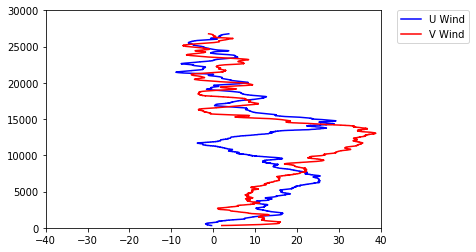

In [93]:
fig = plt.figure()
plt.plot(ds['u_wind'], ds['alt'], 'b-', label='U Wind')
plt.plot(ds['v_wind'], ds['alt'], 'r-', label='V Wind')
plt.xlim(-40, 40)
plt.ylim(0, 30000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [236]:
radar = pyart.io.read('/home/zsherman/dev/training_exercises/data/KLOT20130417_235520_V06.gz')
radar_sweep = radar.extract_sweeps([5])
#radar = pyart.io.read('/home/zsherman/dev/xsapr_sgp/data/05_19_2017/XSW170519071005.RAW54Z8')

In [131]:
gatefilter = pyart.correct.GateFilter(radar_sweep)
gatefilter.exclude_below('reflectivity', 5)
gatefilter.exclude_invalid('velocity')

In [132]:
vad_s = velocity_azimuth_display_scott(
        radar_sweep, 'velocity', z_want=np.linspace(50, 10766, 101), 
        gatefilter=gatefilter)

[False False False ..., False False False]
max height 23349.2962065 meters


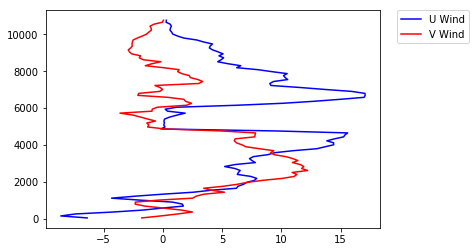

In [133]:
fig = plt.figure()
plt.plot(vad_s.u_wind, vad_s.height, 'b-', label='U Wind')
plt.plot(vad_s.v_wind, vad_s.height, 'r-', label='V Wind')
#plt.xlim(-40, 40)
#plt.ylim(0, 15000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

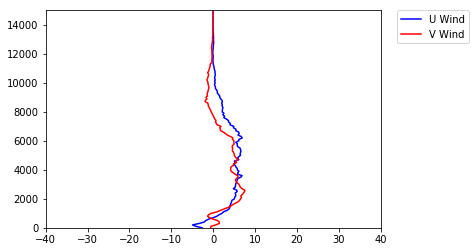

In [64]:
fig = plt.figure()
plt.plot(vad_s.u_wind, vad_s.height, 'b-', label='U Wind')
plt.plot(vad_s.v_wind, vad_s.height, 'r-', label='V Wind')
plt.xlim(-40, 40)
plt.ylim(0, 15000)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [23]:
mystr = ('This is highly experimental and initial data. There are many known'
         + ' and unknown issues. Please do not use before contacting the'
         + ' Translator responsible scollis@anl.gov')
mystr

'This is highly experimental and initial data. There are many known and unknown issues. Please do not use before contacting the Translator responsible scollis@anl.gov'

In [24]:
files = glob.glob('/home/zsherman/misc_data/*')
print(files)

['/home/zsherman/misc_data/sgpxsaprI5.00.20171004.191101.mnt.XSW171004180005.RAWCKXU.maint', '/home/zsherman/misc_data/argentina_1arc_geotiffs', '/home/zsherman/misc_data/sgpsondewnpnC1.b1.20171119.113300.cdf', '/home/zsherman/misc_data/sgpsondewnpnC1.b1.20171119.172400.cdf', '/home/zsherman/misc_data/XSE171004180248.RAWW40T', '/home/zsherman/misc_data/sgpxsaprppiI4.00.20170828.120400.raw.tar', '/home/zsherman/misc_data/2013070308340000dBuZ.azi']


In [59]:
meta_append = {
            'site_id': 'sgp',
            'facility_id': 'I5' + ': ' + 'blah',
            'data_level': 'c1',
            'comment': mystr,
            'attributions': (
                'This data is collected by the ARM Climate Research facility. '
                'Radar system is operated by the radar engineering team ' 
                'radar@arm.gov and the data is processed by the precipitation '
                'radar products team. LP code courtesy of Scott Giangrande '
                'BNL.'),
            'version': '2.0 lite',
            'vap_name': 'cmac',
            'known_issues': (
                'False phidp jumps in insect regions. Still uses old',
                'Giangrande code.'),
            'command_line': 'woot',
            'developers': 'Robert Jackson, ANL. Zachary Sherman, ANL.',
            'translator': 'Scott Collis, ANL.',
            'mentors': ('Nitin Bharadwaj, PNNL. Bradley Isom, PNNL.',
                        'Joseph Hardin, PNNL. Iosif Lindenmaier, PNNL.')}

In [60]:
import json

In [61]:
with open('/home/zsherman/blah.json', 'w') as outfile:
    json.dump(meta_append, outfile)

In [62]:
with open('/home/zsherman/blah.json', 'r') as infile:
    meta_data = json.load(infile)

In [63]:
meta_data

{'attributions': 'This data is collected by the ARM Climate Research facility. Radar system is operated by the radar engineering team radar@arm.gov and the data is processed by the precipitation radar products team. LP code courtesy of Scott Giangrande BNL.',
 'command_line': 'woot',
 'comment': 'This is highly experimental and initial data. There are many known and unknown issues. Please do not use before contacting the Translator responsible scollis@anl.gov',
 'data_level': 'c1',
 'developers': 'Robert Jackson, ANL. Zachary Sherman, ANL.',
 'facility_id': 'I5: blah',
 'known_issues': ['False phidp jumps in insect regions. Still uses old',
  'Giangrande code.'],
 'mentors': ['Nitin Bharadwaj, PNNL. Bradley Isom, PNNL.',
  'Joseph Hardin, PNNL. Iosif Lindenmaier, PNNL.'],
 'site_id': 'sgp',
 'translator': 'Scott Collis, ANL.',
 'vap_name': 'cmac',
 'version': '2.0 lite'}

In [30]:
meta_data + meta_data

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [124]:
arr = np.array([5, 3, 2, 5, 2])

In [125]:
arr = np.ma.masked_equal(arr, 2)

In [126]:
arr

masked_array(data = [5 3 -- 5 --],
             mask = [False False  True False  True],
       fill_value = 2)

In [127]:
print(np.isfinite(arr))

[True True -- True --]


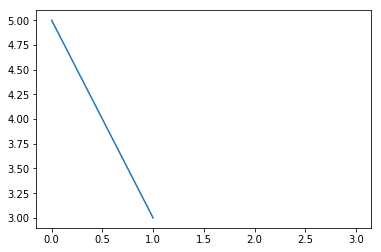

In [128]:
plt.plot(arr)

In [197]:
np.where(np.logical_and(radar.azimuth['data']>=273.9, radar.azimuth['data']<=275.0))

(array([ 200,  201,  888,  889, 1570, 1571, 2260, 2261, 2944, 2945, 3634,
        3635, 4666, 5008, 5351, 5688, 6025, 6359, 6693, 7026, 7327, 7656,
        7978]),)

In [8]:
import pyart
import matplotlib.pyplot as plt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [9]:
print(pyart.__version__)

1.9.1


In [10]:
print(pyart)

<module 'pyart' from '/home/zsherman/anaconda3/lib/python3.5/site-packages/pyart/__init__.py'>


In [11]:
radar = pyart.io.read('/home/zsherman/pyart_data/sgpcsaprsurcmacI7.c0.20110520.095101.nc')

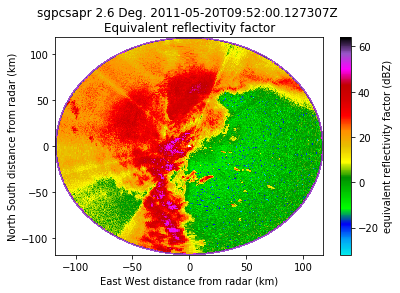

CPU times: user 608 ms, sys: 240 ms, total: 848 ms
Wall time: 501 ms


In [244]:
%%time
fig = plt.figure()
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('reflectivity_horizontal', 3, vmin=-32, vmax=64., edges=True)
plt.show()

In [1]:
import glob

In [4]:
files = glob.glob('/home/zsherman/dev/cmac2.0/data/')
files

['/home/zsherman/dev/cmac2.0/data/']

In [17]:
radar

NameError: name 'radar' is not defined

In [42]:
radar.metadata.clear()
radar.metadata.update(meta_data)

In [43]:
radar.metadata

{'attributions': ['This data is collected by the ARM Climate Research facility.',
  'Radar system is operated by the radar engineering team',
  'radar@arm.gov and the data is processed by the precipitation',
  'radar products team. LP code courtesy of Scott Giangrande',
  'BNL.'],
 'command_line': 'woot',
 'comment': 'This is highly experimental and initial data. There are many known and unknown issues. Please do not use before contacting the Translator responsible scollis@anl.gov',
 'data_level': 'c1',
 'developers': 'Robert Jackson, ANL. Zachary Sherman, ANL.',
 'facility_id': 'I5: blah',
 'known_issues': ['False phidp jumps in insect regions. Still uses old',
  'Giangrande code.'],
 'mentors': ['Nitin Bharadwaj, PNNL. Bradley Isom, PNNL.',
  'Joseph Hardin, PNNL. Iosif Lindenmaier, PNNL.'],
 'site_id': 'sgp',
 'translator': 'Scott Collis, ANL.',
 'vap_name': 'cmac',
 'version': '2.0 lite'}

In [39]:
dir(radar.metadata)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [2]:
config_xsapr_i6 = {
    'fields': {
        'reflectivity': 'reflectivity',
        'velocity': 'doppler_velocity',
        'cross_correlation_ratio': 'cross_correlation_ratio',
        'normalized_coherent_power': 'normalized_coherent_power'},
    'sonde': {'temperature': 'tdry',
              'height': 'alt'},
    'save_name': 'sgpxsaprcmacsurI6.c1',
    'facility': 'I6',
    'town': 'Deer Creek, OK',
    'x_compass': 'XNW',
    'site_alt': 341,
    'coef': 0.914,
    'attenuation_a_coef': 0.17,
    'field_shape': (8280, 501),
    'max_lat': 37.3,
    'min_lat': 36.25,
    'max_lon': -96.9,
    'min_lon': -98.2,
    'site_i6_dms_lat': (36, 46, 2.28),
    'site_i6_dms_lon': (-97, 32, 53.16),
    'site_i5_dms_lat': (36, 29, 29.4),
    'site_i5_dms_lon': (-97, 35, 37.68),
    'site_i4_dms_lat': (36, 34, 44.4),
    'site_i4_dms_lon': (-97, 21, 49.32)}

In [3]:
config_xsapr_i6['sonde']['temperature']

'tdry'

In [5]:
print(config_xsapr_i6)

{'site_alt': 341, 'town': 'Deer Creek, OK', 'site_i4_dms_lon': (-97, 21, 49.32), 'site_i5_dms_lon': (-97, 35, 37.68), 'site_i5_dms_lat': (36, 29, 29.4), 'sonde': {'temperature': 'tdry', 'height': 'alt'}, 'x_compass': 'XNW', 'max_lon': -96.9, 'facility': 'I6', 'site_i6_dms_lat': (36, 46, 2.28), 'attenuation_a_coef': 0.17, 'min_lon': -98.2, 'site_i6_dms_lon': (-97, 32, 53.16), 'fields': {'velocity': 'doppler_velocity', 'reflectivity': 'reflectivity', 'normalized_coherent_power': 'normalized_coherent_power', 'cross_correlation_ratio': 'cross_correlation_ratio'}, 'min_lat': 36.25, 'coef': 0.914, 'save_name': 'sgpxsaprcmacsurI6.c1', 'field_shape': (8280, 501), 'max_lat': 37.3, 'site_i4_dms_lat': (36, 34, 44.4)}


In [78]:
blah = []

In [82]:
blah.append((([2, 3, 4]), 3, 5))

In [83]:
blah

[([2, 3, 4], 3, 5)]

In [85]:
radar.altitude['data']

array([ 327.60000229])

In [13]:
radar.metadata['command_line'] = 'foobar'

In [14]:
radar.metadata

{'Conventions': 'CF/Radial',
 'command_line': 'foobar',
 'dod_version': '1.0',
 'experiment': 'MC3E',
 'facility': 'I7',
 'facility_id': 'I7: Nardin, Oklahoma',
 'history': 'created by user sc8 on bds2-vm1 at 23-Jan-2013,20:48:08 using ./process_and_save_csapr_params.py',
 'input_datastreams_num': '2',
 'instrument_name': 'sgpcsapr',
 'instrument_type': 'radar',
 'platform_is_mobile': 'False',
 'platform_type': 'fixed',
 'primary_axis': 'axis_z',
 'site_id': 'sgp',
 'source': 'MDV radar volume file created by Dsr2Vol.',
 'volume_number': 0}